In [4]:
import pandas as pd
import nflfastpy as nfl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [6]:
df = pd.DataFrame()
for year in range(2015, 2020):
    yearly_df = nfl.load_pbp_data(year)
    df = pd.concat([df, yearly_df])

In [7]:
rushing_df_filters = (df['rush_attempt'] == 1) & (df['two_point_attempt'] == 0)
rushing_df = df.loc[rushing_df_filters, ['rush_attempt', 'rush_touchdown', 'yardline_100']]
rushing_df_probs = rushing_df.groupby('yardline_100')['rush_touchdown'].value_counts(normalize=True)
rushing_df_probs = pd.DataFrame({
    'probability_of_touchdown': rushing_df_probs.values
}, index=rushing_df_probs.index).reset_index()
rushing_df_probs = rushing_df_probs.loc[rushing_df_probs['rush_touchdown'] == 1, ['yardline_100', 'probability_of_touchdown']]
rushing_df_probs.head()

,yardline_100,probability_of_touchdown
0,1.0,0.560390
3,2.0,0.428058
5,3.0,0.336910
7,4.0,0.304251
9,5.0,0.206349


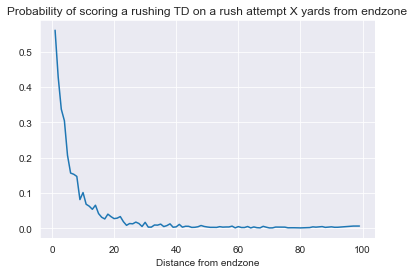

In [8]:
plt.plot(rushing_df_probs['yardline_100'], rushing_df_probs['probability_of_touchdown']);
plt.title('Probability of scoring a rushing TD on a rush attempt X yards from endzone');
plt.xlabel('Distance from endzone');

In [10]:
df_2020 = nfl.load_pbp_data(2020)

In [11]:
roster_2020 = nfl.load_2020_roster_data()
rbs = roster_2020.loc[roster_2020['position'] == 'RB']['gsis_id']
rbs.head()

60    00-0033118
61    00-0034681
62    00-0033797
63    00-0036383
64    00-0032577
Name: gsis_id, dtype: object

In [13]:
rushing_df_2020 = df_2020.loc[df_2020['rush_attempt'] == 1, 
['rusher_id', 'rusher_player_name', 'rush_attempt','rush_touchdown', 'yardline_100']]

rushing_df_2020 = rushing_df_2020.loc[rushing_df_2020['rusher_id'].isin(rbs)]

rushing_df_2020 = rushing_df_2020.merge(rushing_df_probs, how='left', on='yardline_100')

rushing_df_2020 = rushing_df_2020.groupby('rusher_id', as_index=False).agg({
    'rusher_player_name': 'first', 'rush_touchdown': 'sum', 'probability_of_touchdown': 'sum'
}).rename({
    'probability_of_touchdown': 'expected_touchdowns', 'rush_touchdown': 'actual_touchdowns'
}, axis=1)
rushing_df_2020['positive_regression_candidate'] = rushing_df_2020['actual_touchdowns'] < rushing_df_2020['expected_touchdowns']
rushing_df_2020['delta'] = rushing_df_2020.apply(
    lambda x: abs(x.expected_touchdowns - x.actual_touchdowns), axis=1
)
rushing_df_2020.sort_values(by='expected_touchdowns', ascending=False).head(50)

,rusher_id,rusher_player_name,actual_touchdowns,expected_touchdowns,positive_regression_candidate,delta
57,00-0033893,D.Cook,16.0,15.776227,False,0.223773
36,00-0032764,D.Henry,17.0,14.290648,False,2.709352
43,00-0033118,K.Drake,10.0,13.998086,True,3.998086
42,00-0033045,E.Elliott,6.0,13.545488,True,7.545488
115,00-0035700,J.Jacobs,12.0,12.721041,True,0.721041
59,00-0033906,A.Kamara,17.0,11.702657,False,5.297343
130,00-0036223,J.Taylor,12.0,11.379692,False,0.620308
27,00-0032241,T.Gurley,9.0,9.212286,True,0.212286
46,00-0033293,A.Jones,10.0,9.141680,False,0.858320
114,00-0035685,D.Montgomery,8.0,8.957086,True,0.957086


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


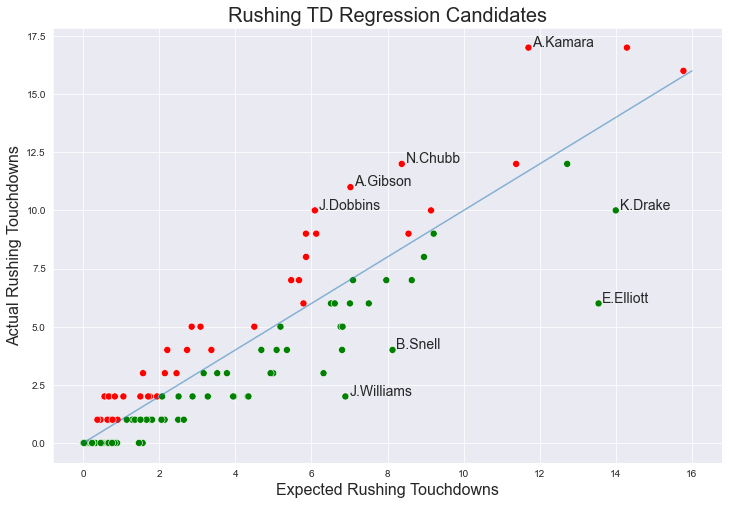

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    x = 'expected_touchdowns',
    y = 'actual_touchdowns',
    hue = 'positive_regression_candidate',
    data = rushing_df_2020,
    palette = ['r', 'g'], # red and green,
    s=50
);

max_act_touchdowns = int(rushing_df_2020['actual_touchdowns'].max()) # max touchdowns
max_exp_touchdowns = int(rushing_df_2020['expected_touchdowns'].max()) # max expected touchdowns

max_tds = max(max_act_touchdowns, max_exp_touchdowns) # max of actual and expected tds

sns.lineplot(range(max_tds), range(max_tds), alpha=0.5); # plotting a line with slope of 1 up to max_tds number. This is the blue line on our viz

#15 players with the highest delta between expected and actual TDs (negative or positive)
top_x_delta = rushing_df_2020.sort_values(by='delta', ascending=False)[:8]

for _, row in top_x_delta.iterrows(): 
    ax.text(
        x = row['expected_touchdowns']+.1, # add a bit of spacing from the point in the x-direction
        y = row['actual_touchdowns'] + 0.05, # same but in the y-direction
        s = row['rusher_player_name'], # annotate with the player's name,
        fontsize=14
    )
ax.get_legend().remove()
ax.set_title('Rushing TD Regression Candidates', fontsize=20)
ax.set_xlabel('Expected Rushing Touchdowns', fontsize=16)
ax.set_ylabel('Actual Rushing Touchdowns', fontsize=16);

In [19]:

top_x_delta

,rusher_id,rusher_player_name,actual_touchdowns,expected_touchdowns,positive_regression_candidate,delta
42,00-0033045,E.Elliott,6.0,13.545488,True,7.545488
59,00-0033906,A.Kamara,17.0,11.702657,False,5.297343
62,00-0033948,J.Williams,2.0,6.890506,True,4.890506
99,00-0035217,B.Snell,4.0,8.130330,True,4.130330
43,00-0033118,K.Drake,10.0,13.998086,True,3.998086
138,00-0036328,A.Gibson,11.0,7.023938,False,3.976062
127,00-0036158,J.Dobbins,10.0,6.089412,False,3.910588
87,00-0034791,N.Chubb,12.0,8.372476,False,3.627524
